# 0.0 Imports

In [42]:
import pickle
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import psycopg2 as pg
import matplotlib.patches as mpatches

from tabulate import tabulate
from pycorrcat import pycorrcat
from IPython.display import HTML
from IPython.display import Image
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from credentials.credentialsdb import acess

from sklearn import ensemble as en
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
    display( HTML( '<style>.container{width:100% !important; }</style>'))
#    pd.options.display.max_columns = None
#   pd.options.display.max_rows = None
#    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimeis
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    # ignora future warnings
    warnings.filterwarnings('ignore')
    
    sns.set()

In [3]:
jupyter_settings()

## 0.2 Load Data

In [4]:
# Credentials
host = acess.get('host')
port = acess.get('port')
database = acess.get('database')
username = acess.get('username')
password = acess.get('password')

# acess database
conn = pg.connect(user=username,
                  password = password,
                  host = host,
                  port = port,
                  database = database)

# make a cursor into database
cursor = conn.cursor()

# verify all schemas
query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
    """

cursor.execute(query_schema)
record = cursor.fetchall()
record

[('pg_toast',),
 ('pg_temp_1',),
 ('pg_toast_temp_1',),
 ('pg_catalog',),
 ('information_schema',),
 ('public',),
 ('pa004',),
 ('pg_temp_4',),
 ('pg_toast_temp_4',),
 ('pa005',),
 ('pg_temp_9',),
 ('pg_toast_temp_9',)]

In [5]:
# Verify tables from the schema
#query_tables = """
#    SELECT tablename
#    FROM pg_tables
#    WHERE schemaname='pa004'
#    """

#cursor.execute(query_tables)
#record = cursor.fetchall()
#record

In [6]:
# Collect tables into dataframe
query_tables_insurance = """
    SELECT *
    FROM pa004.users u INNER JOIN pa004.vehicle v ON (u.id = v.id)
                       INNER JOIN pa004.insurance i ON (u.id = i.id)
    """

df_raw = pd.read_sql(query_tables_insurance, conn)

# close connection into database
cursor.close()
conn.close()

# 1.0 Descrição dos dados

In [7]:
df1 = df_raw.copy()

In [8]:
# drop duplicates id columns
df1 = df1.loc[:, ~df1.columns.duplicated()].copy()
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.00,152.00,1,< 1 Year,Yes,0,23367.00,249,0
1,13,Female,41,15.00,14.00,1,1-2 Year,No,1,31409.00,221,0
2,18,Female,25,35.00,152.00,1,< 1 Year,No,1,46622.00,299,0
3,31,Female,26,8.00,160.00,1,< 1 Year,No,0,2630.00,136,0
4,39,Male,45,8.00,124.00,1,1-2 Year,Yes,0,42297.00,264,0


## 1.2 Data Dimension

In [9]:
print(f'Number os rows: {df1.shape[0]}')
print(f'Number os cols: {df1.shape[1]}')

Number os rows: 381109
Number os cols: 12


## 1.3 Data Types

In [10]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.7 Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.7.1 Numerical Attributes

In [13]:
# Central tendency and Dispersion
d1 = pd.DataFrame (num_attributes.apply( lambda x: x.max() - x.min() )).T
d2 = num_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concatenate
m2 = pd.concat([d1, d2]).T.reset_index()
m2.columns = ['attibutes', 'range', 'min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis']
m2 = m2[['attibutes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]

m2

,attibutes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.00,381109.00,381108.00,190555.00,190555.00,110016.84,-0.00,-1.20
1,age,20.00,85.00,65.00,38.82,36.00,15.51,0.67,-0.57
2,region_code,0.00,52.00,52.00,26.39,28.00,13.23,-0.12,-0.87
3,policy_sales_channel,1.00,163.00,162.00,112.03,133.00,54.20,-0.90,-0.97
4,driving_license,0.00,1.00,1.00,1.00,1.00,0.05,-21.60,464.35
5,previously_insured,0.00,1.00,1.00,0.46,0.00,0.50,0.17,-1.97
6,annual_premium,2630.00,540165.00,537535.00,30564.39,31669.00,17213.16,1.77,34.00
7,vintage,10.00,299.00,289.00,154.35,154.00,83.67,0.00,-1.20
8,response,0.00,1.00,1.00,0.12,0.00,0.33,2.30,3.30


### 1.7.2 Categorical Attributes

In [14]:
cat_attributes.apply( lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

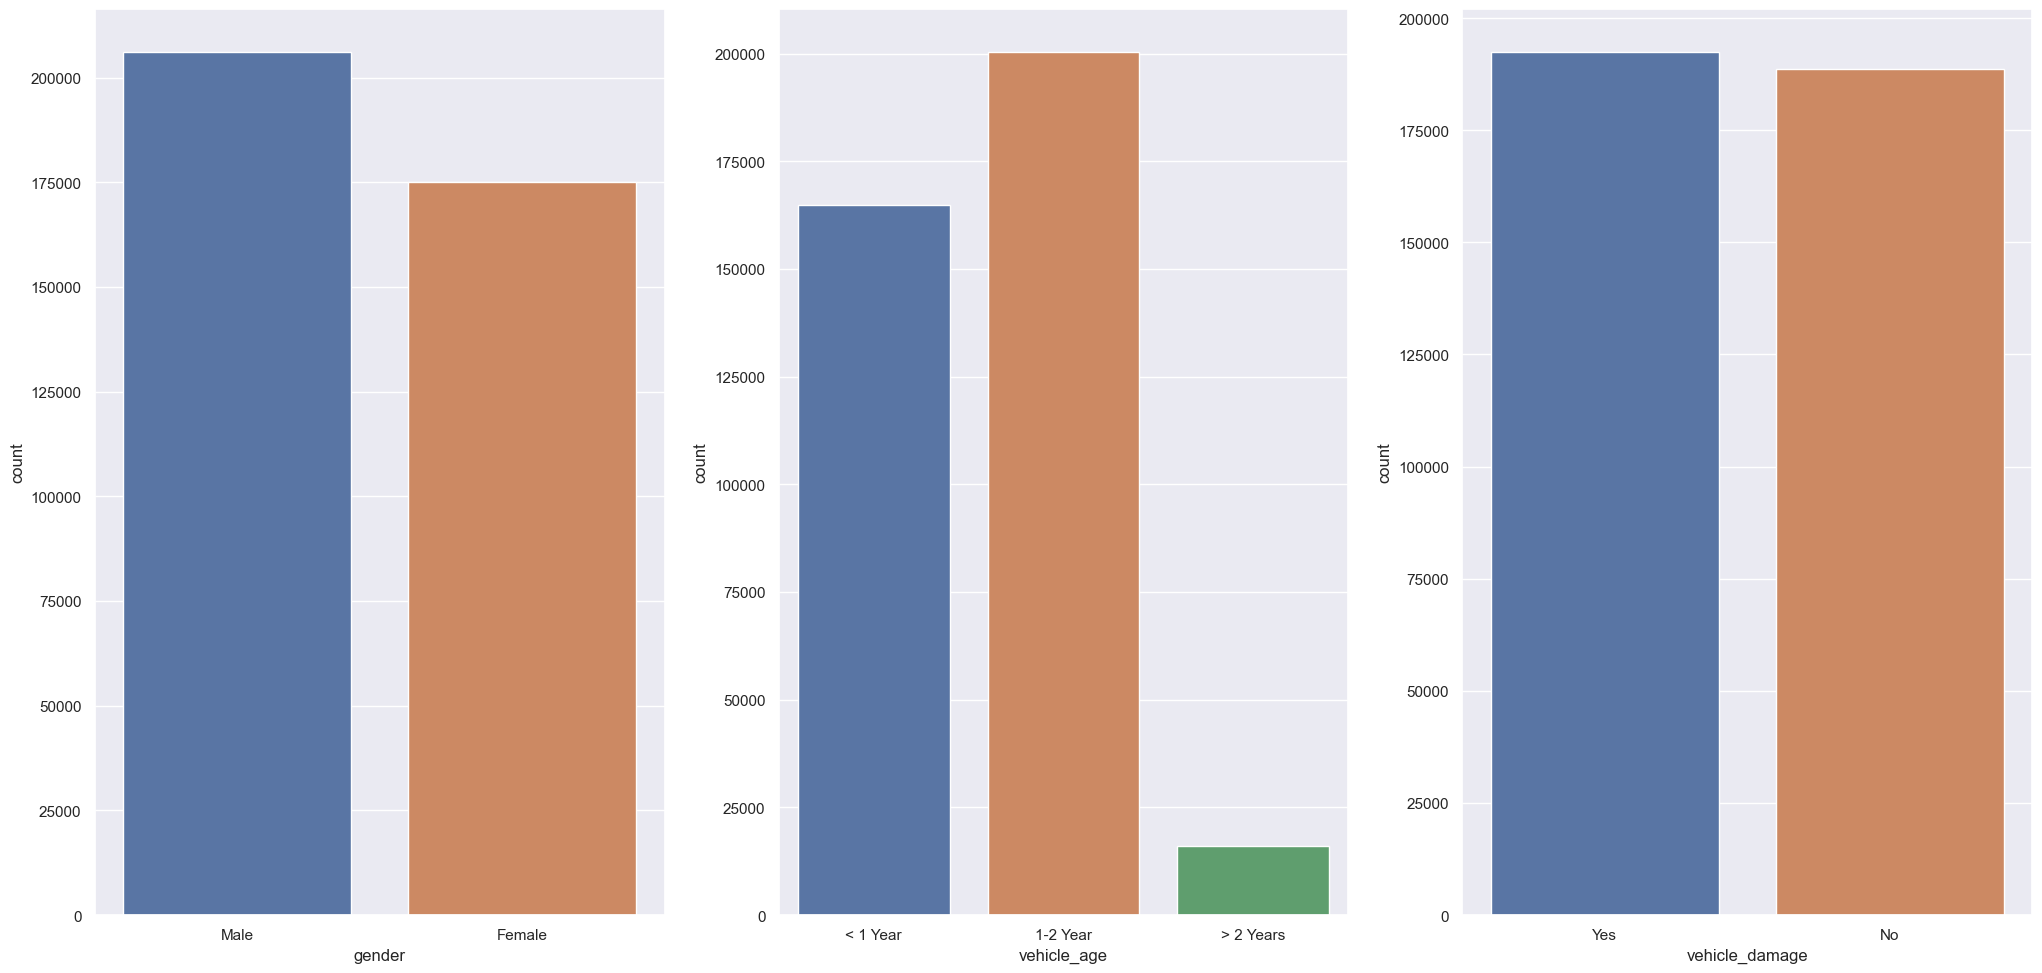

In [15]:
plt.subplot (1, 3, 1)
sns.countplot(x='gender', data=df1)

plt.subplot (1, 3, 2)
sns.countplot(x='vehicle_age', data=df1)

plt.subplot (1, 3, 3)
sns.countplot(x='vehicle_damage', data=df1);

# 2.0 Feature Engineering

In [16]:
df2 = df1.copy()

## 2.1 MindMap Hypothesis

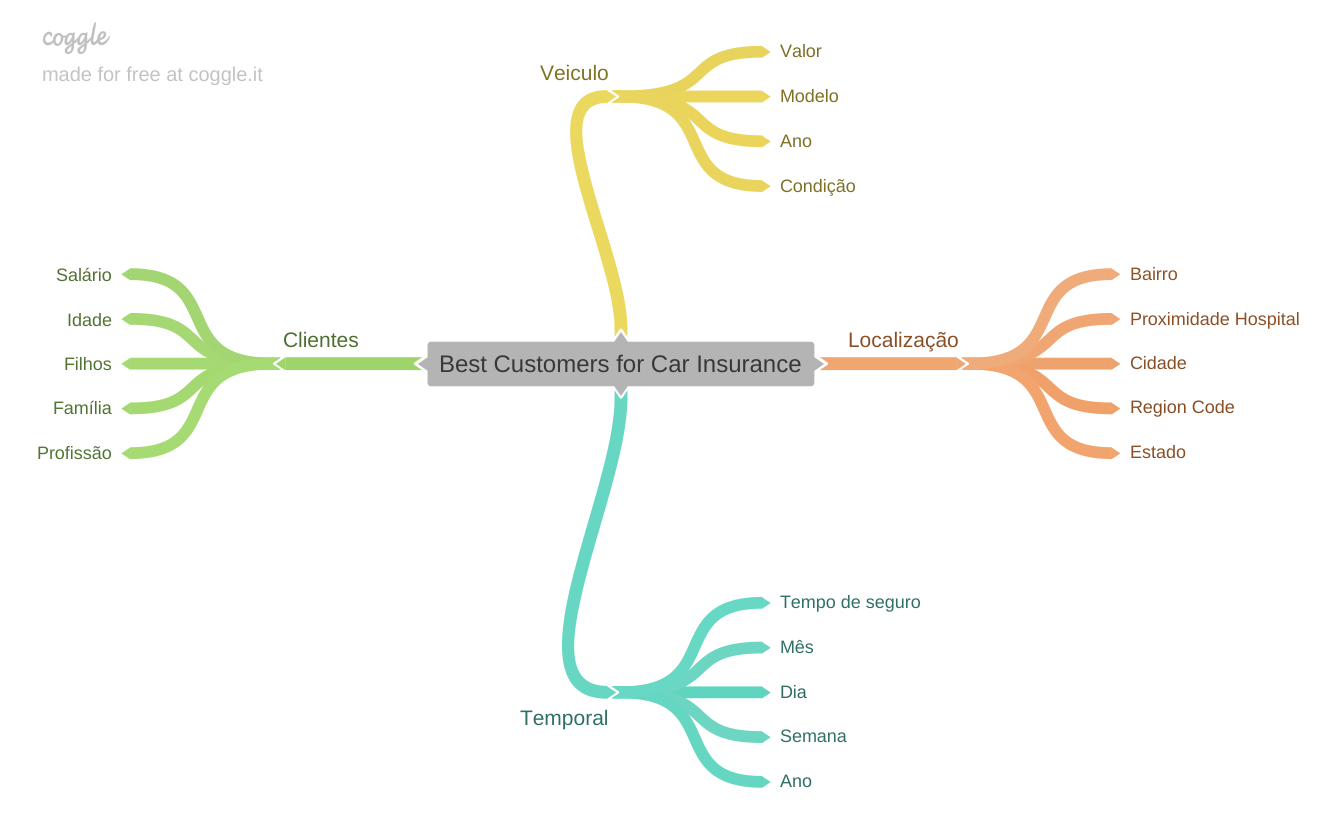

In [17]:
Image('F:/SamuelOliveiraAlvesd/Desktop/Data_Science/Projetos/Health_Insurance_Cross_Sell/reports/figures/Best_Customers_for_Car_Insurance.png')

## 2.1.1 Hipóteses Veiculo

**1.** Pessoas que possuem carro mais caros possuem maior interesse em seguro

**2.** Pessoas com carros de modelo popular possuem menos interesse em seguro

**3.** Pessoas com carros comprados recentemente possuem maior interesse em seguro

**4.** Pessoas que o carro já foi danificado possuem maior interesse em seguro em relação aos que não foram danificados


## 2.1.2 Hipóteses Cliente

**1.** Pessoas com maiores salarios possuem mais interesse em seguros

**2.** Pessoas mais velhas possuem maior interesse em seguro

**3.** Pessoas com filhos possuem maior interesse em seguro

**4.** Pessoas com familia possuem maior interesse em seguro 

## 2.1.3 Hipóteses Localização

**1.** Pessoas próximas de hospitais possuem mais interesse em seguro

**2.** Pessoas em diferentes regiões possuem maior interesse em seguro

## 2.1.4 Hipóteses Tempo

**1.** Pessoas com mais tempo com seguro tem maior interesse em outros seguros

**2.** Pessoas possuem maior interesse em seguro no inverno.

**3.** Pessoas possuem maior interesse em seguro nos dias de feriado

**4.** Existe maior interesse em seguros com o passar dos anos.

## 2.2 Lista final de hipóteses

**1.** Pessoas com carros comprados recentemente possuem maior interesse em seguro

**2.** Pessoas que o carro já foi danificado possuem maior interesse em seguro

**3.** Pessoas mais velhas possuem maior interesse em seguro

**4.** Pessoas em melhores regiões possuem maior interesse em seguro

**5.** Pessoas com mais tempo com seguro tem maior interesse em outros seguros

## 2.3 Feature Engineering

In [18]:
# adjust format into vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years'
                                                        else 'between_1_2_year' if x == '1-2 Year'
                                                        else 'below_1_year')


# Convert categorical into numeric
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x=='Yes' else 0)

# 3.0 Filtragem de variáveis

In [19]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [20]:
# select only annual_premium bellow 65.000
df3 = df3[df3['annual_premium'] < 65000]

## 3.2 Seleção das colunas

In [21]:
# Select only who has driving license
df3 = df3[df3['driving_license'] == 1]

# drop driving license column
df3.drop(columns='driving_license', inplace=True)

# 4.0 Análise exploratória dos dados

In [22]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

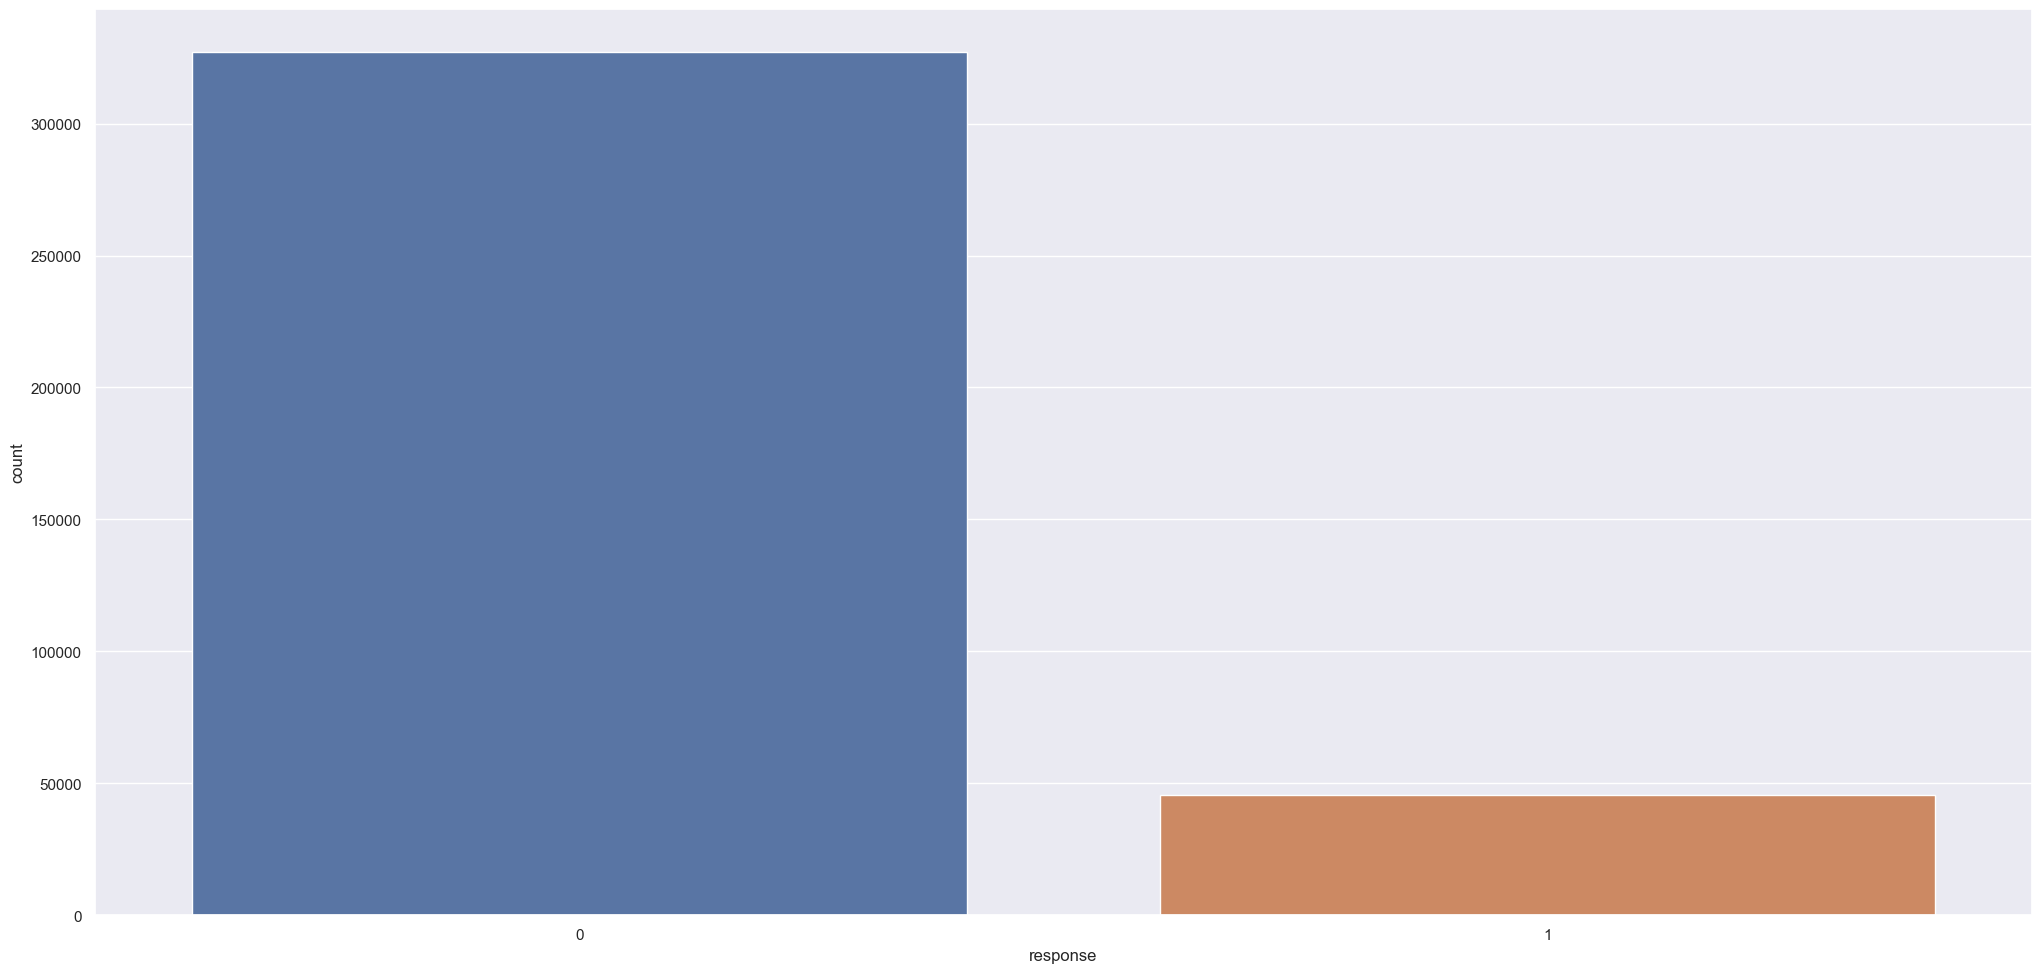

In [23]:
sns.countplot(x='response', data=df4);

### 4.1.2 Numerical Variable

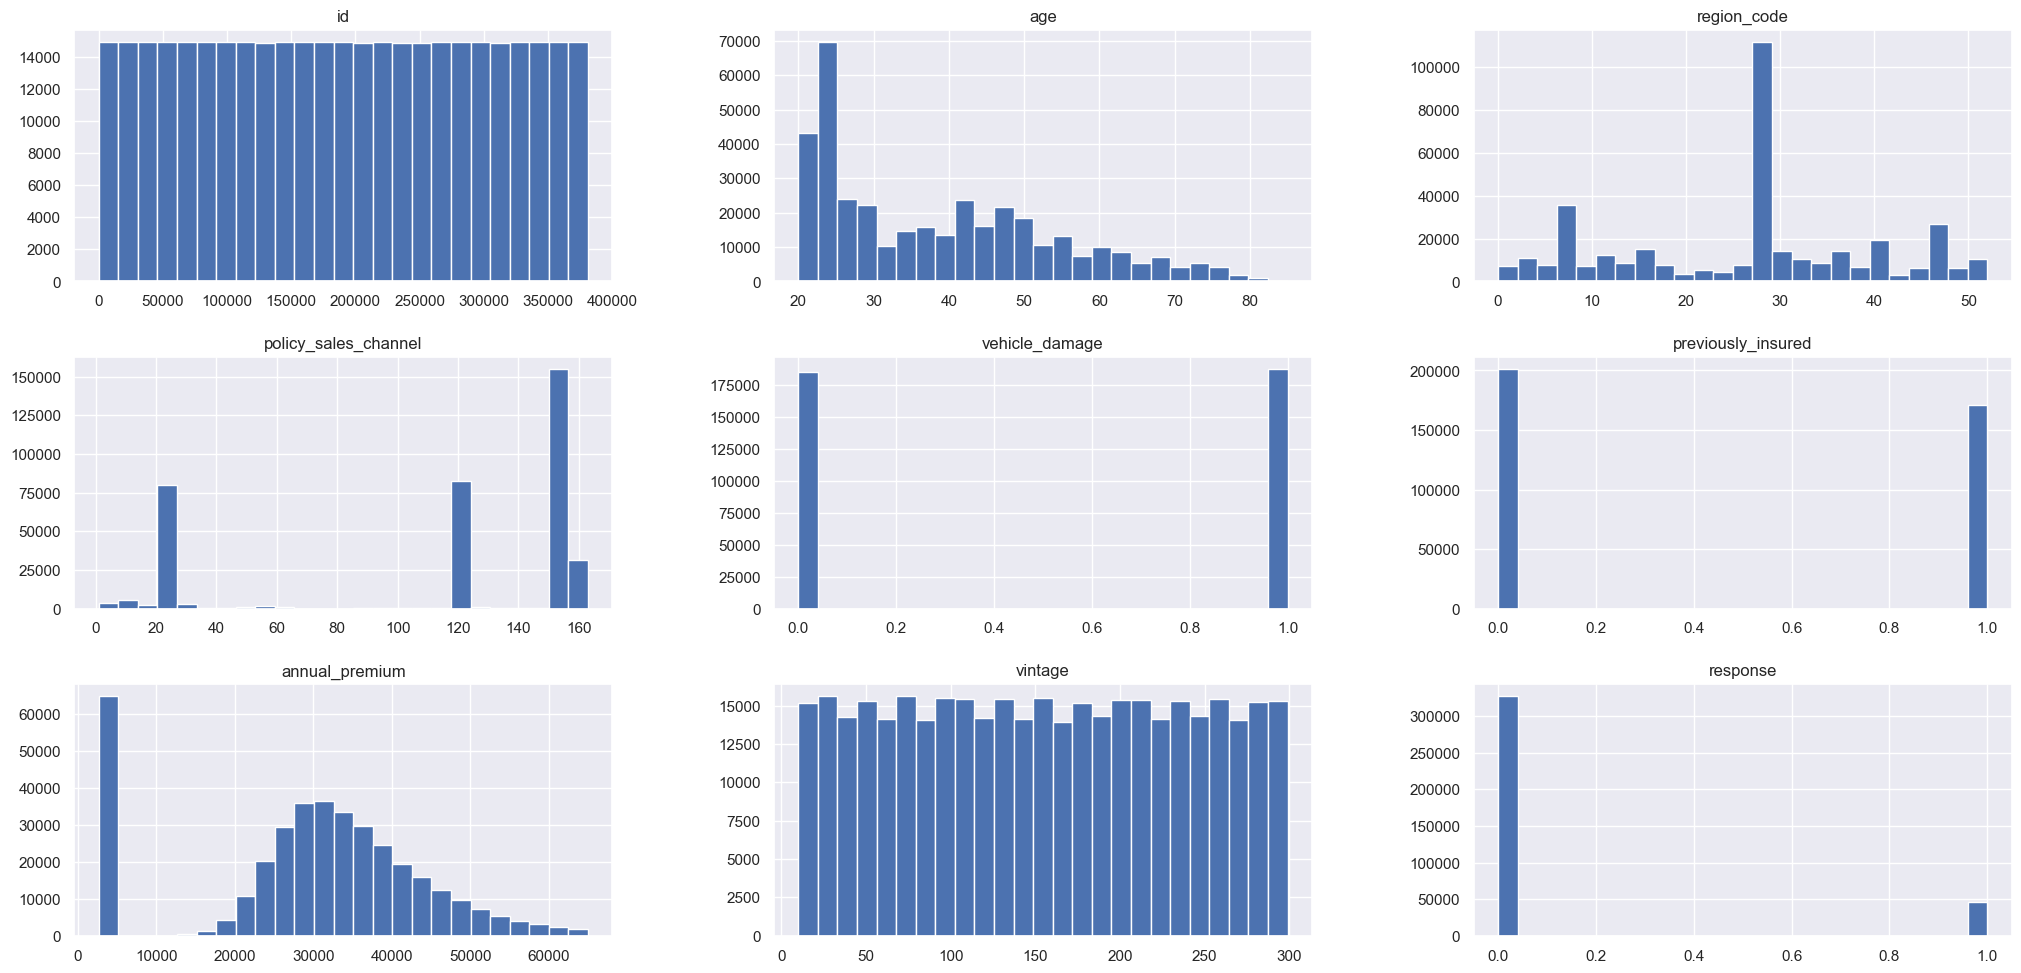

In [24]:
num_attributes = df4.select_dtypes(include='number')
num_attributes.hist(bins=25);

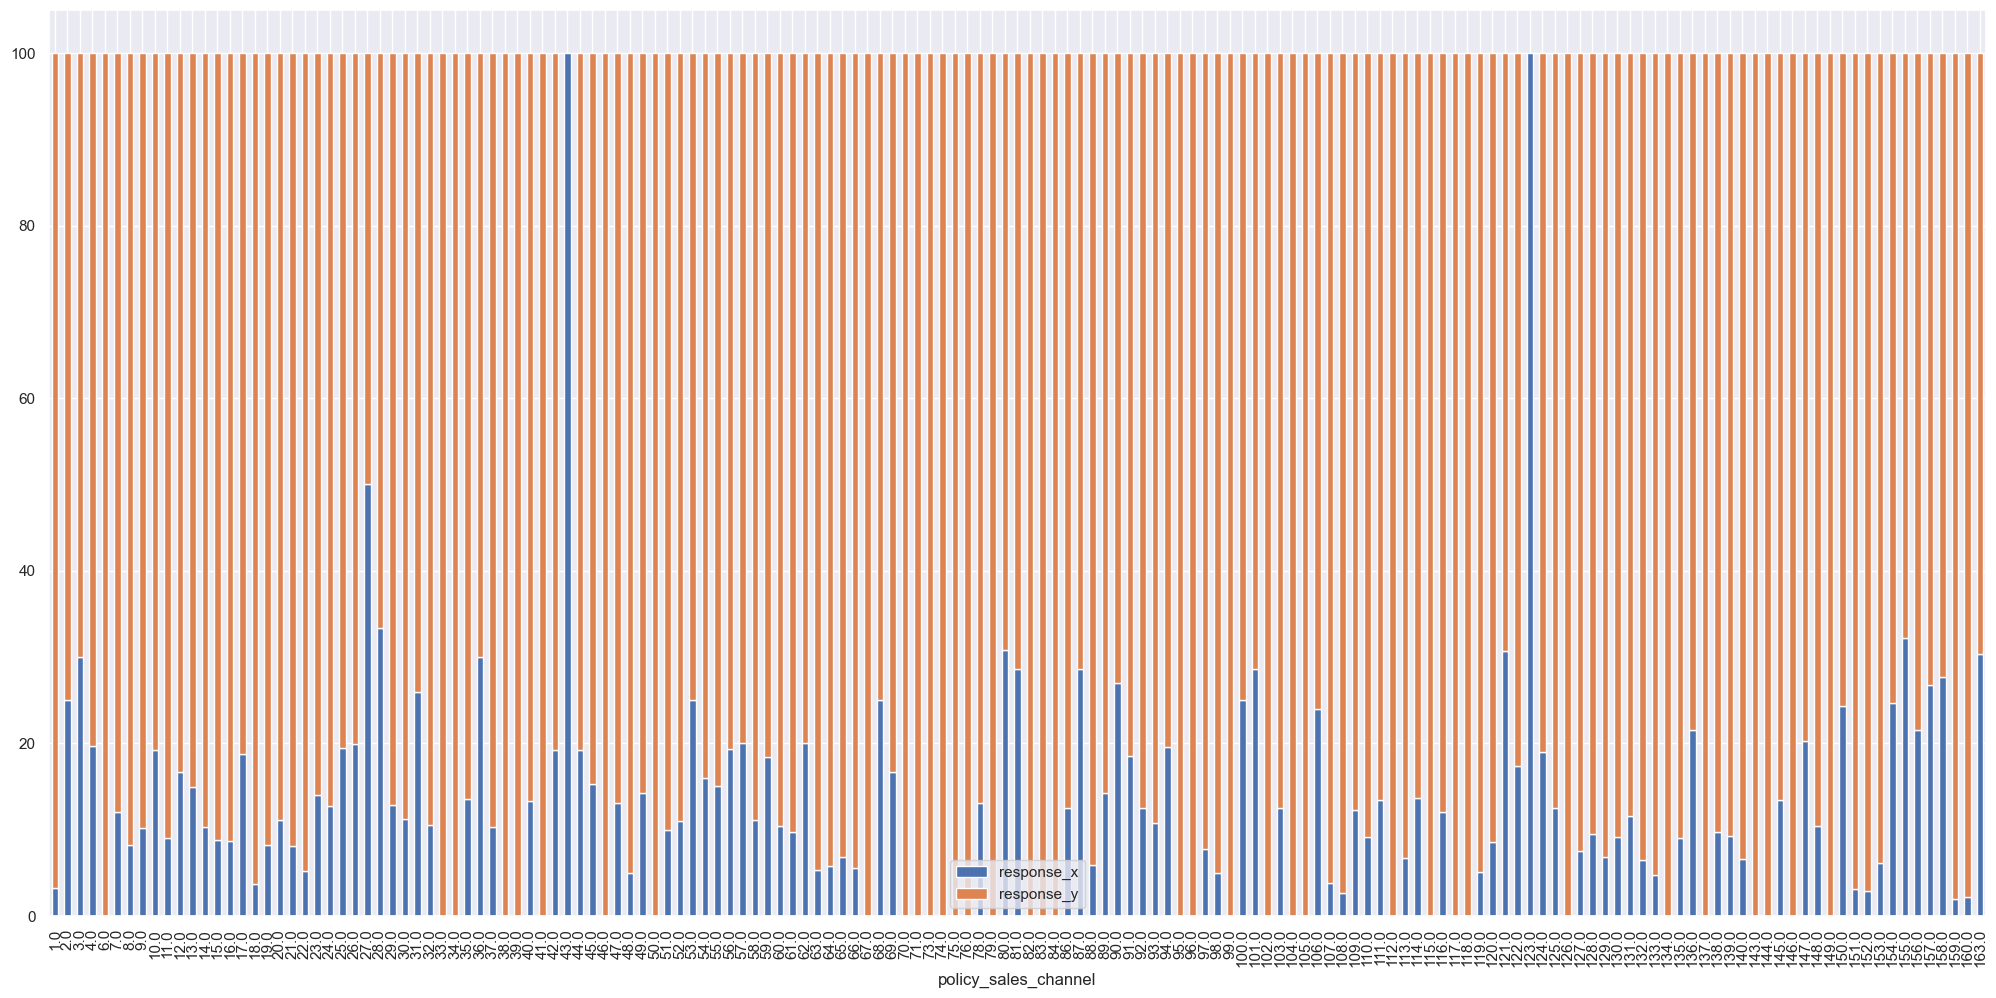

In [25]:
#policy_sales_channel
# count responses per channel
aux01 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
aux02 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').count().reset_index()

# merge and make percentage
aux03 = pd.merge(aux01, aux02, how='inner', on='policy_sales_channel')
aux03['response_x'] = aux03.apply(lambda x: x['response_x'] / x['response_y'] * 100, axis=1)
aux03['response_y'] = aux03.apply(lambda x: 100 - x['response_x'], axis=1)

# plot
aux03.plot(x = 'policy_sales_channel', kind = 'bar', stacked = True);

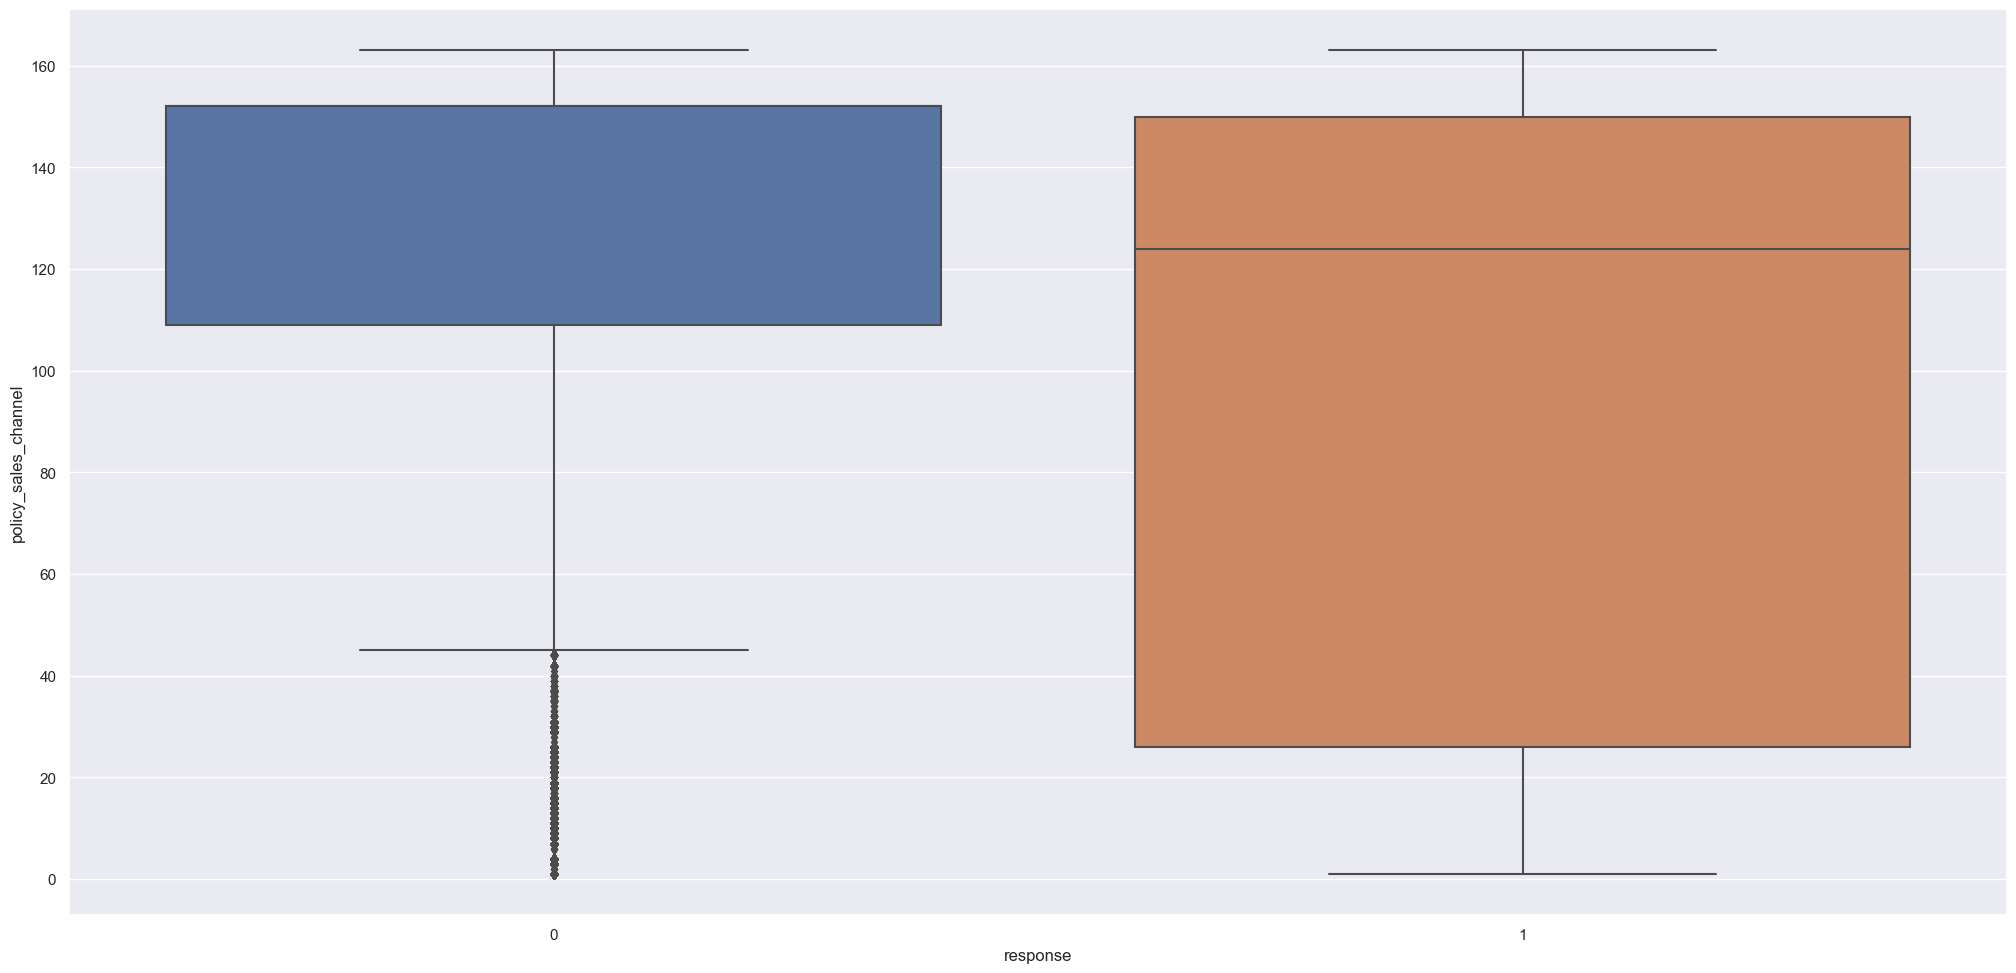

In [26]:
sns.boxplot(x='response', y='policy_sales_channel', data=df4);

In [27]:
# previously_insured
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x : x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.77,0.23
1,1.00,0.00


### 4.1.3 Categorical Variable

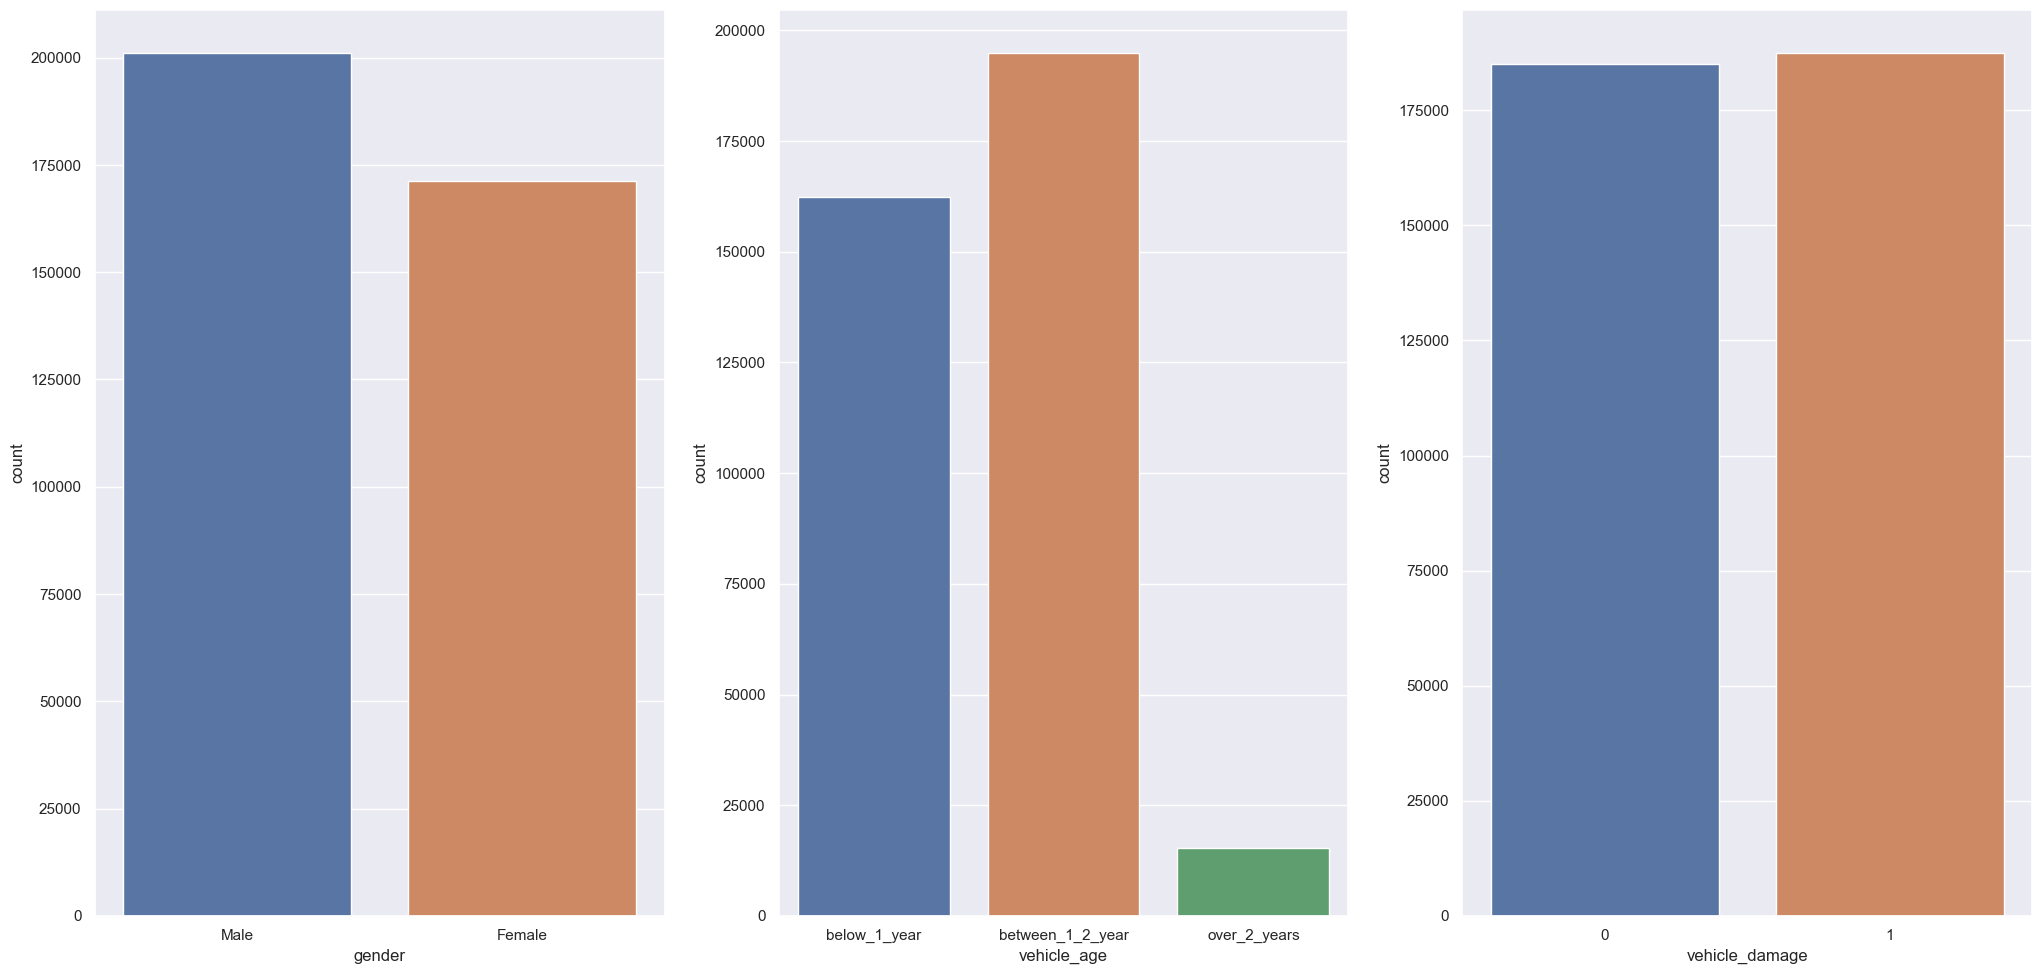

In [28]:
# gender
plt.subplot (1, 3, 1)
sns.countplot(x='gender', data=df4)

# vehicle_age
plt.subplot (1, 3, 2)
sns.countplot(x='vehicle_age', data=df4)

# vehicle_damage
plt.subplot (1, 3, 3)
sns.countplot(x='vehicle_damage', data=df4);

## 4.2 Análise Bivariada

### H1. Pessoas com carros comprados recentemente possuem maior interesse em seguro
**FALSA** Pessoas com carros antigos possuem maior interesse em seguro

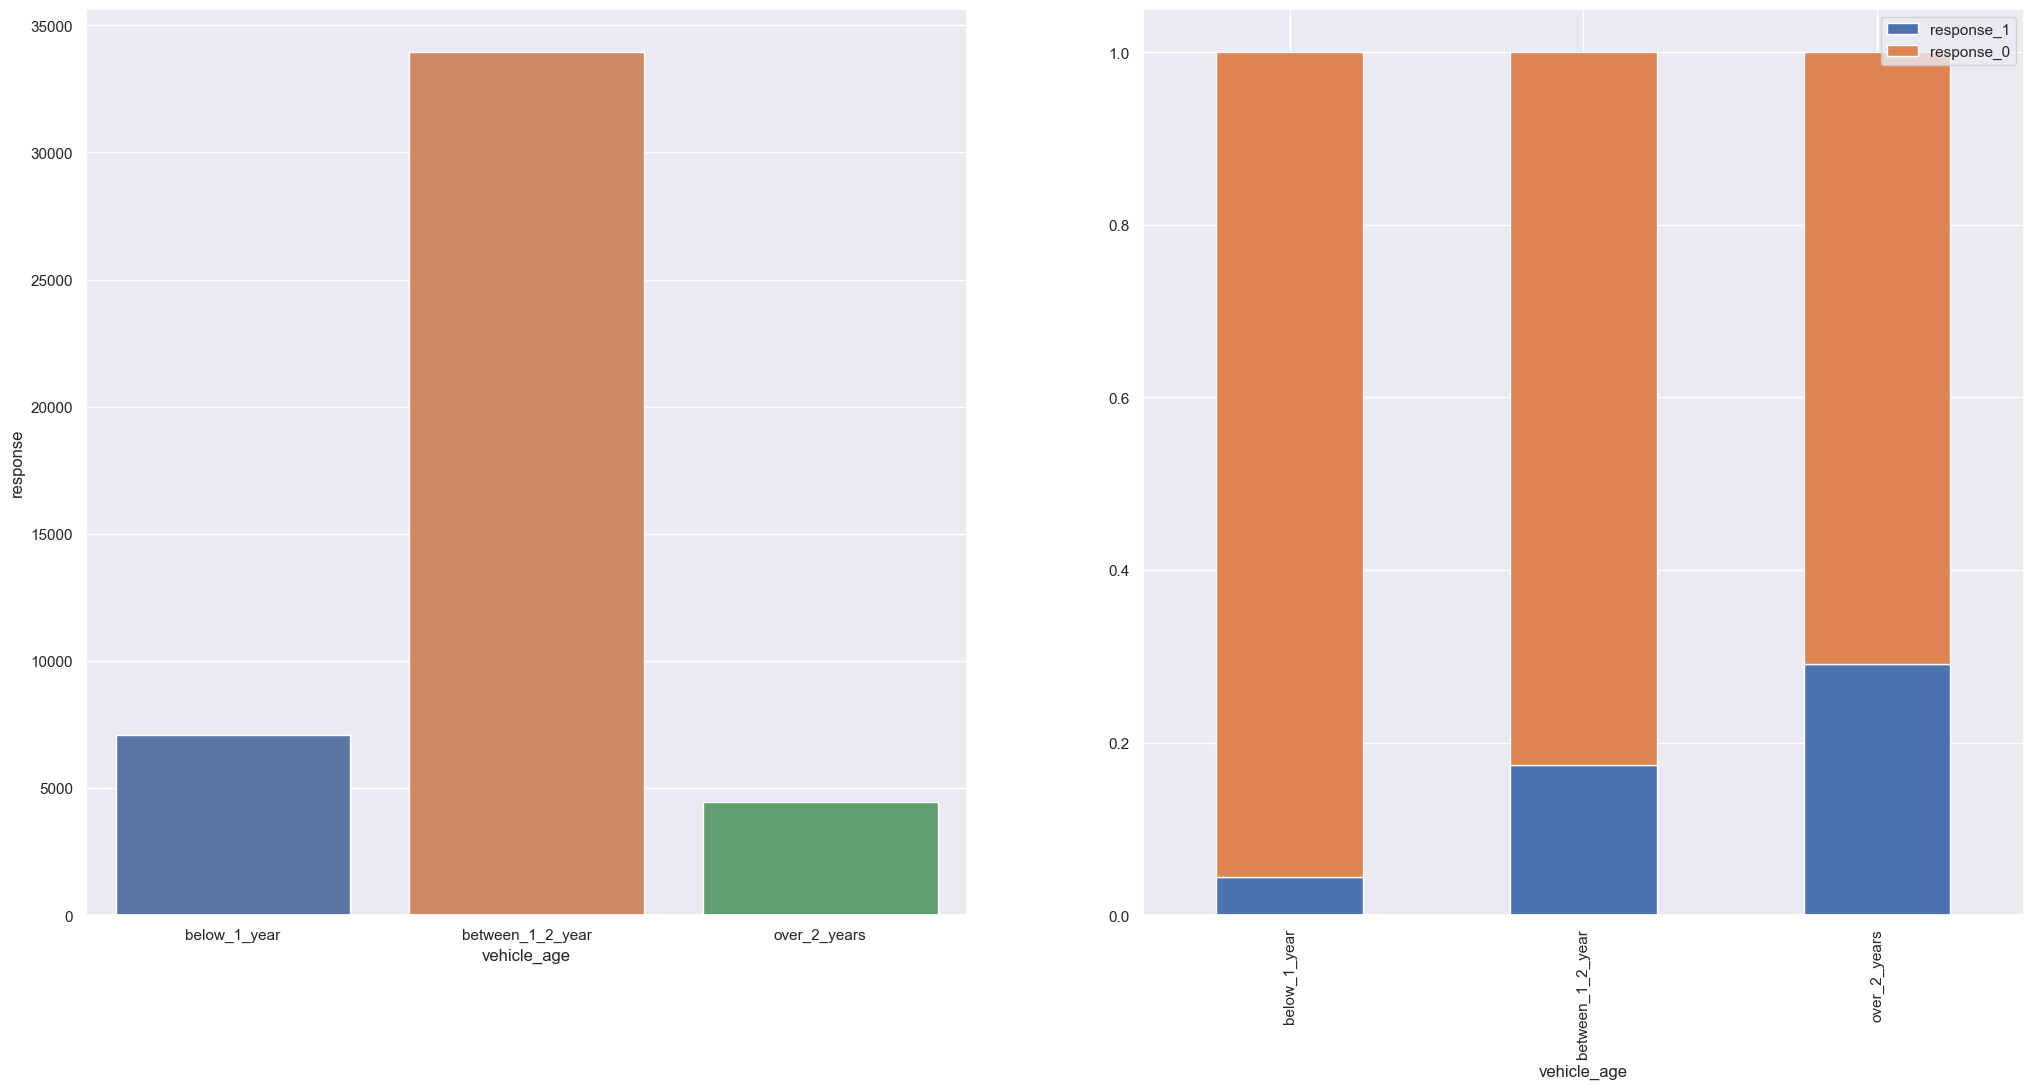

In [29]:
# plot for absolute response per vehicle age
plt.subplot(1, 2, 1)

aux01 = df4[['vehicle_age', 'response']].groupby('vehicle_age').sum().reset_index()
sns.barplot(x='vehicle_age', y='response', data=aux01);

# plot for percentages response per vehicle age
ax = plt.subplot(1, 2, 2)

aux02 = pd.crosstab(df4['vehicle_age'], df4['response']).apply(lambda x: x / x.sum(), axis=1).reset_index()
columns = ['vehicle_age', 'response_0', 'response_1']
aux02.columns = columns
aux02 = aux02[['vehicle_age', 'response_1', 'response_0']]

aux02.plot(x = 'vehicle_age', kind = 'bar', stacked = True, ax=ax);

### H2. Pessoas que o carro já foi danificado possuem maior interesse em seguro em relação aos que não foram danificados
**VERDADEIRA** Pessoas que tiveram o carro danificado demontram maior interesse em seguro, entretanto a maioria ainda não prefere.

In [30]:
aux1 = pd.crosstab(df4['vehicle_damage'], df4['response'])
aux1.apply(lambda x: x / x.sum(), axis=1)

response,0,1
vehicle_damage,,
0,0.99,0.01
1,0.76,0.24


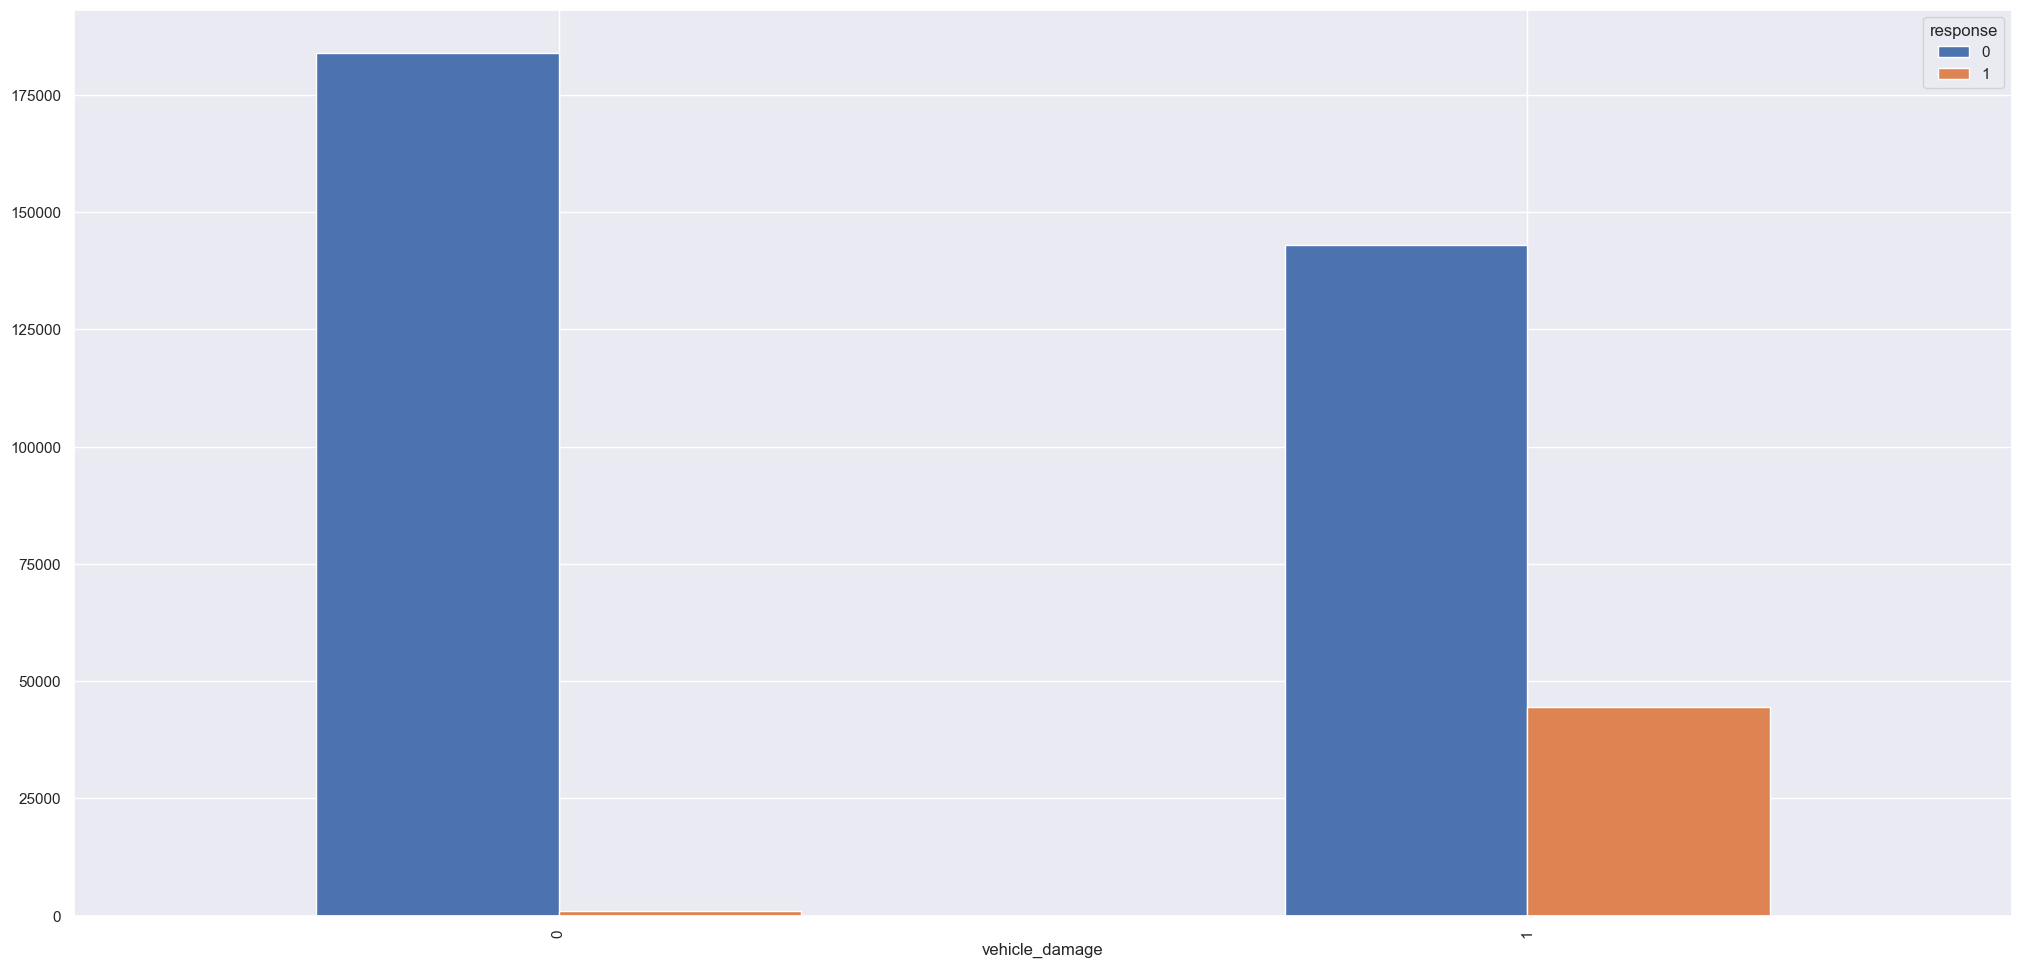

In [31]:
aux1.plot(kind='bar');

### H3. Pessoas mais velhas possuem maior interesse em seguro
**FALSO** Pessoas mais velhas possuem menor interesse em seguro a partir de 40 anos.

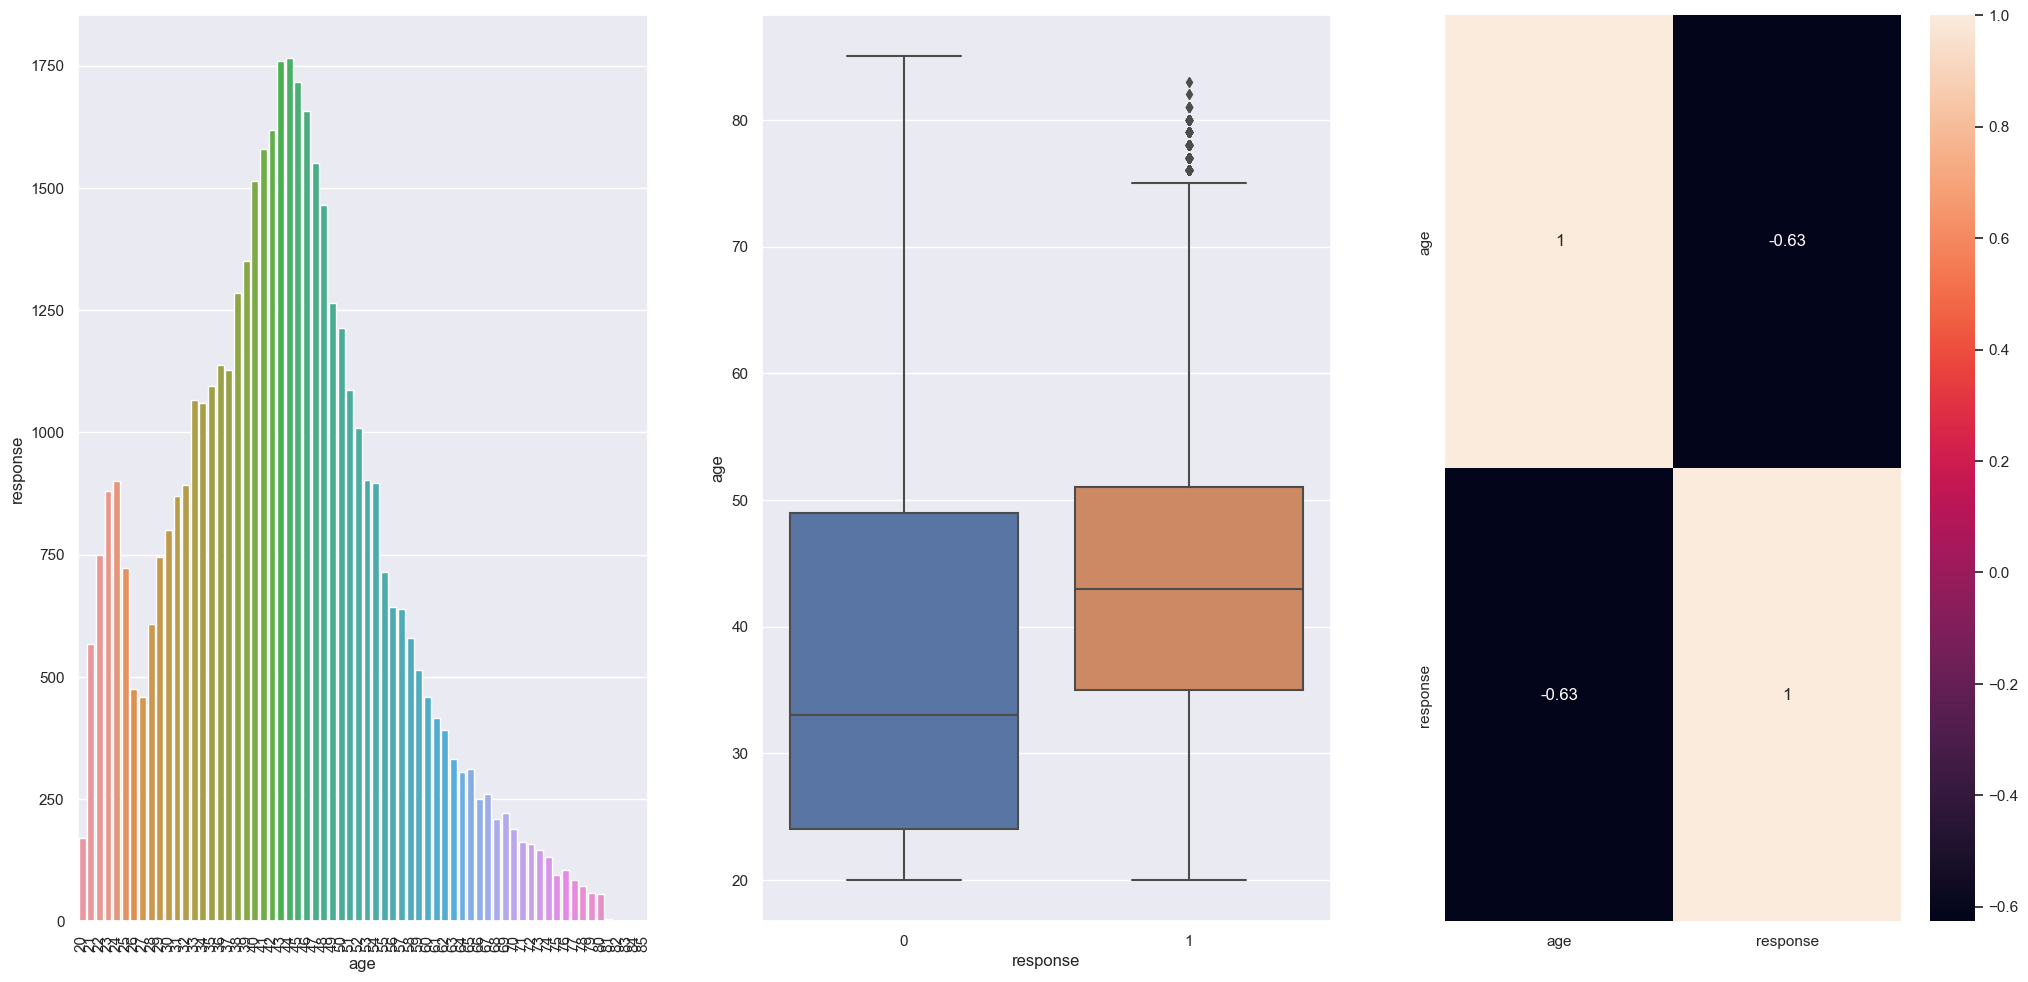

In [32]:
plt.subplot(1, 3, 1)
aux1 = df4[['age', 'response']].groupby('age').sum().reset_index()
sns.barplot(x='age', y='response', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.boxplot(x='response', y='age', data=df4)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Pessoas em diferentes regiões possuem maior interesse em seguro
**VERDADEIRA** Existem regiões com maiores interesse em seguro.

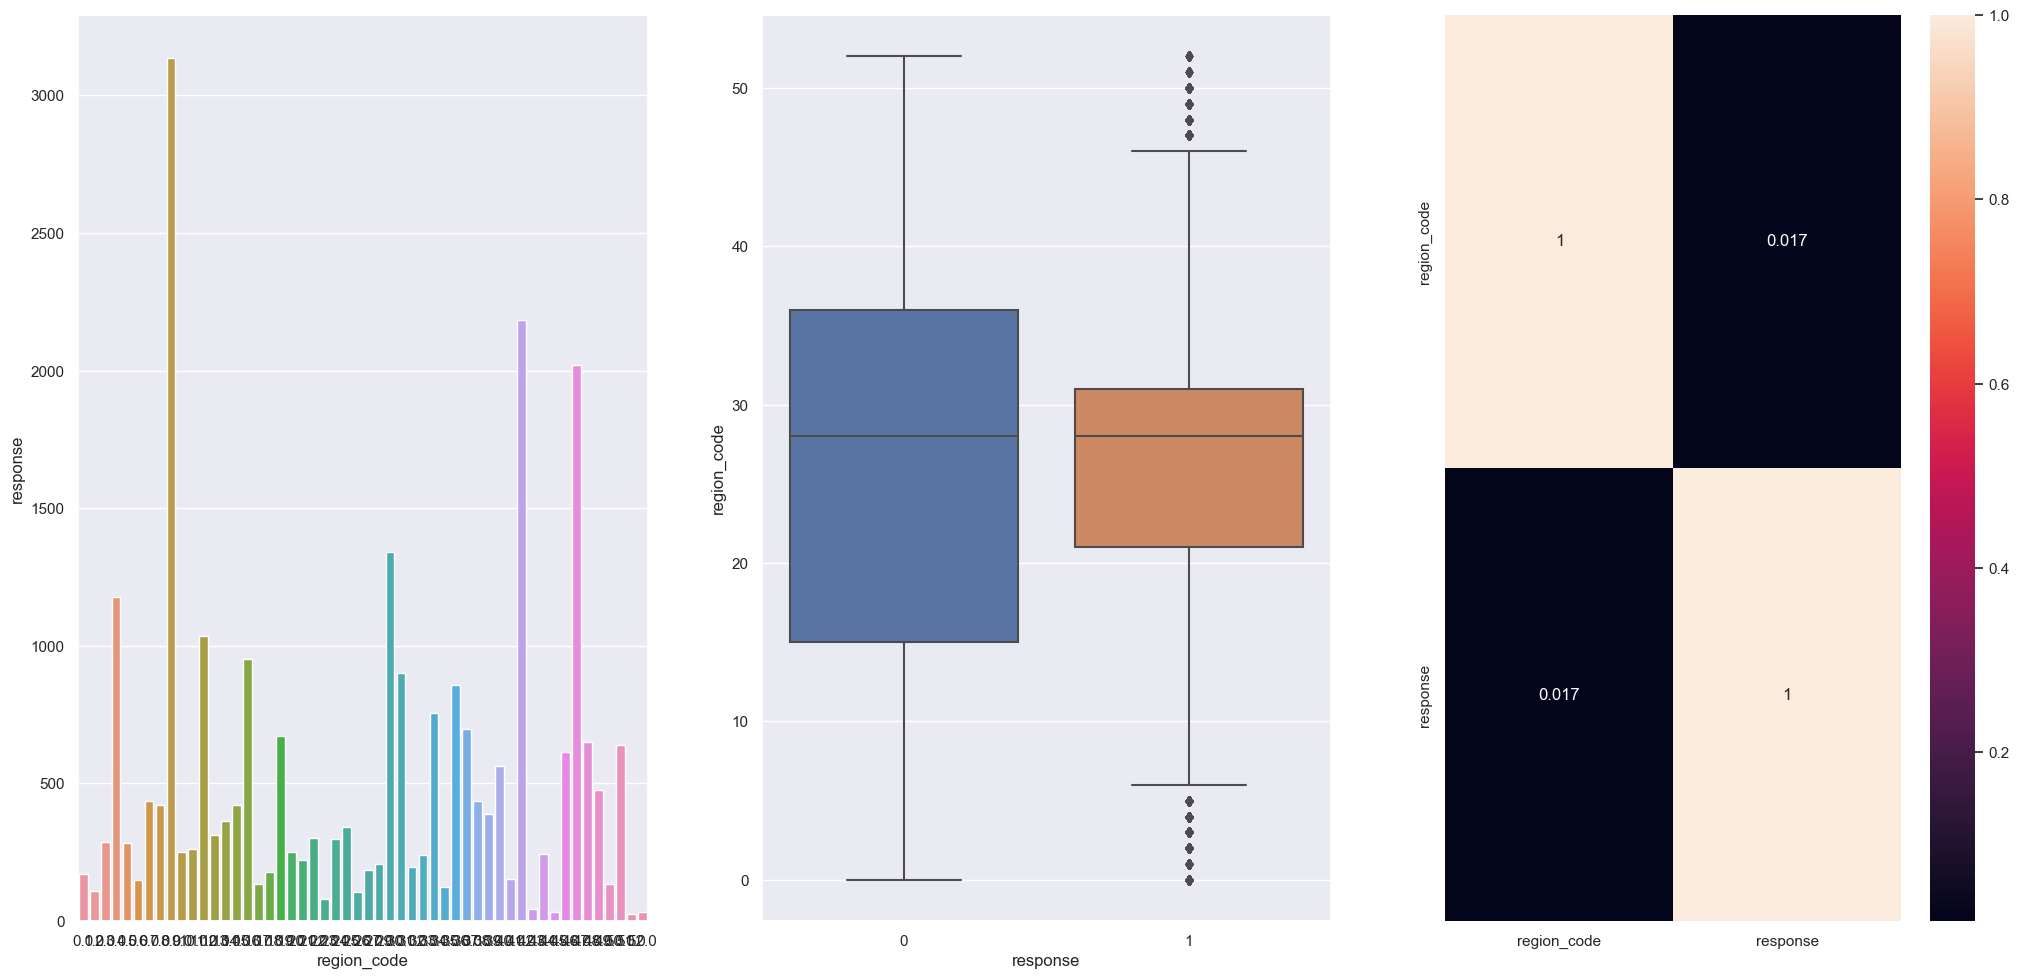

In [33]:
plt.subplot(1, 3, 1)
aux1 = df4[['region_code', 'response']].groupby('region_code').sum().reset_index()
aux2 = aux1[aux1['response'] < 4000]

sns.barplot(x='region_code', y='response', data=aux2)

plt.subplot(1, 3, 2)
sns.boxplot(x='response', y='region_code', data=df4)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H5. Pessoas com mais tempo com seguro tem maior interesse em outros seguros
**FALSA** Pessoas com maior tempo de seguro são indiferentes das com menores tempos.

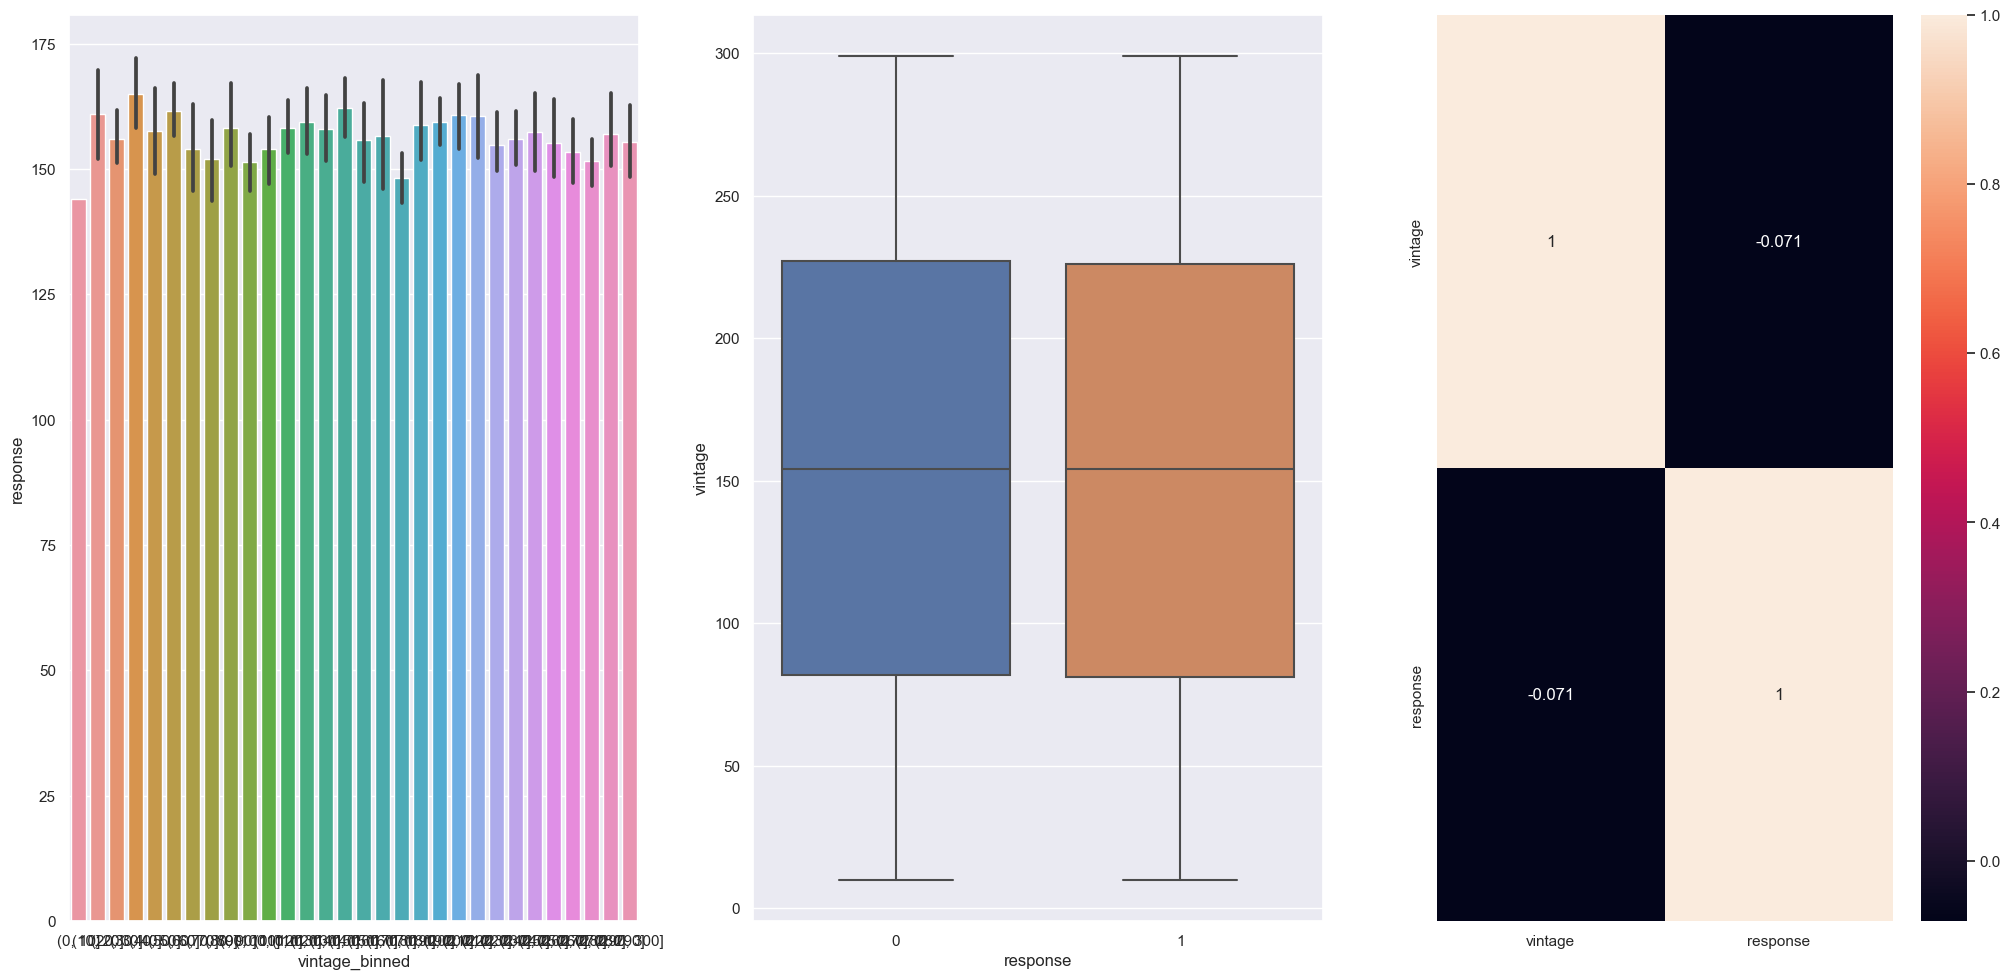

In [34]:
plt.subplot(1, 3, 1)
aux1 = df4[['vintage', 'response']].groupby('vintage').sum().sort_values('vintage').reset_index()
bins = list(np.arange(0, 310, 10))
aux1['vintage_binned'] = pd.cut(aux1['vintage'], bins = bins)

sns.barplot(x='vintage_binned', y='response', data=aux1)


plt.subplot(1, 3, 2)
sns.boxplot(x='response', y='vintage', data=df4)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.1 Resumo das Hipóteses

In [59]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Verdadeira', 'Médio'],
       ['H3', 'Falsa', 'Alto'],
       ['H4', 'Verdadeira', 'Baixa'],
       ['H5', 'Falsa', 'Baixa'],
      ]
print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Verdadeira   Médio
H3           Falsa        Alto
H4           Verdadeira   Baixa
H5           Falsa        Baixa


## 4.3 Análise Multivariada

### 4.3.1 Atributos numéricos

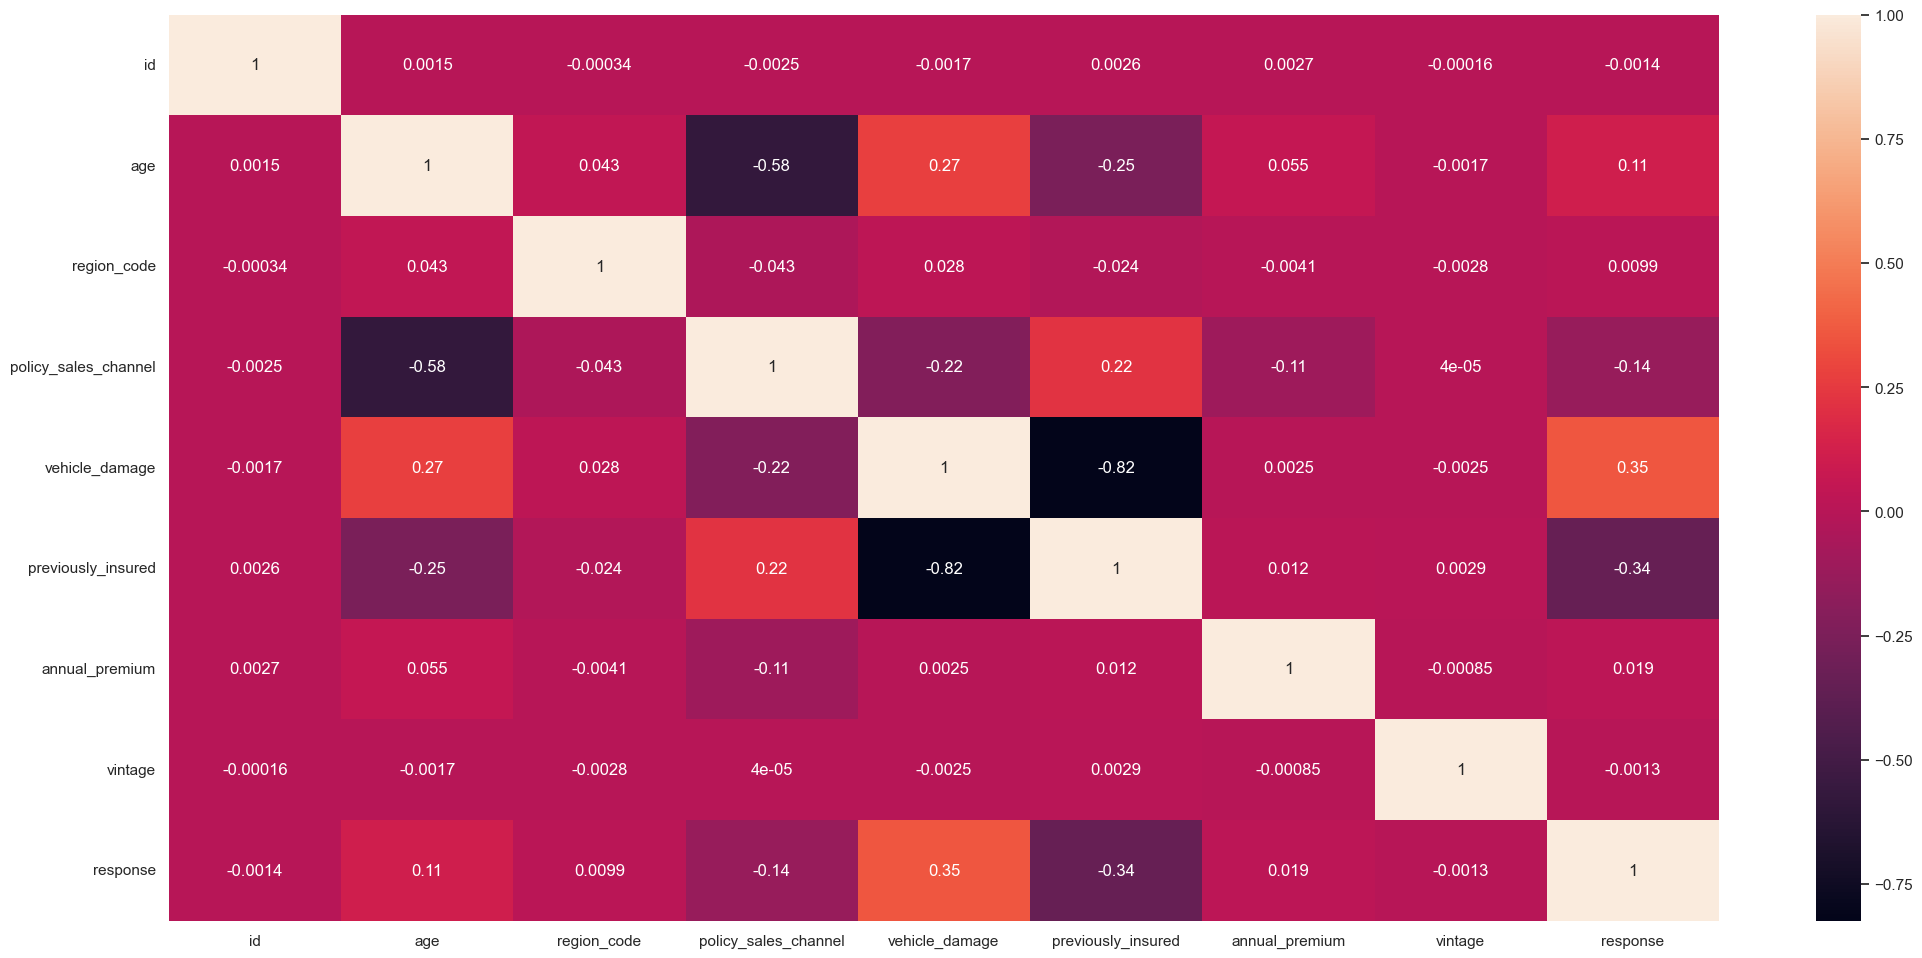

In [36]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Atributos categóricos

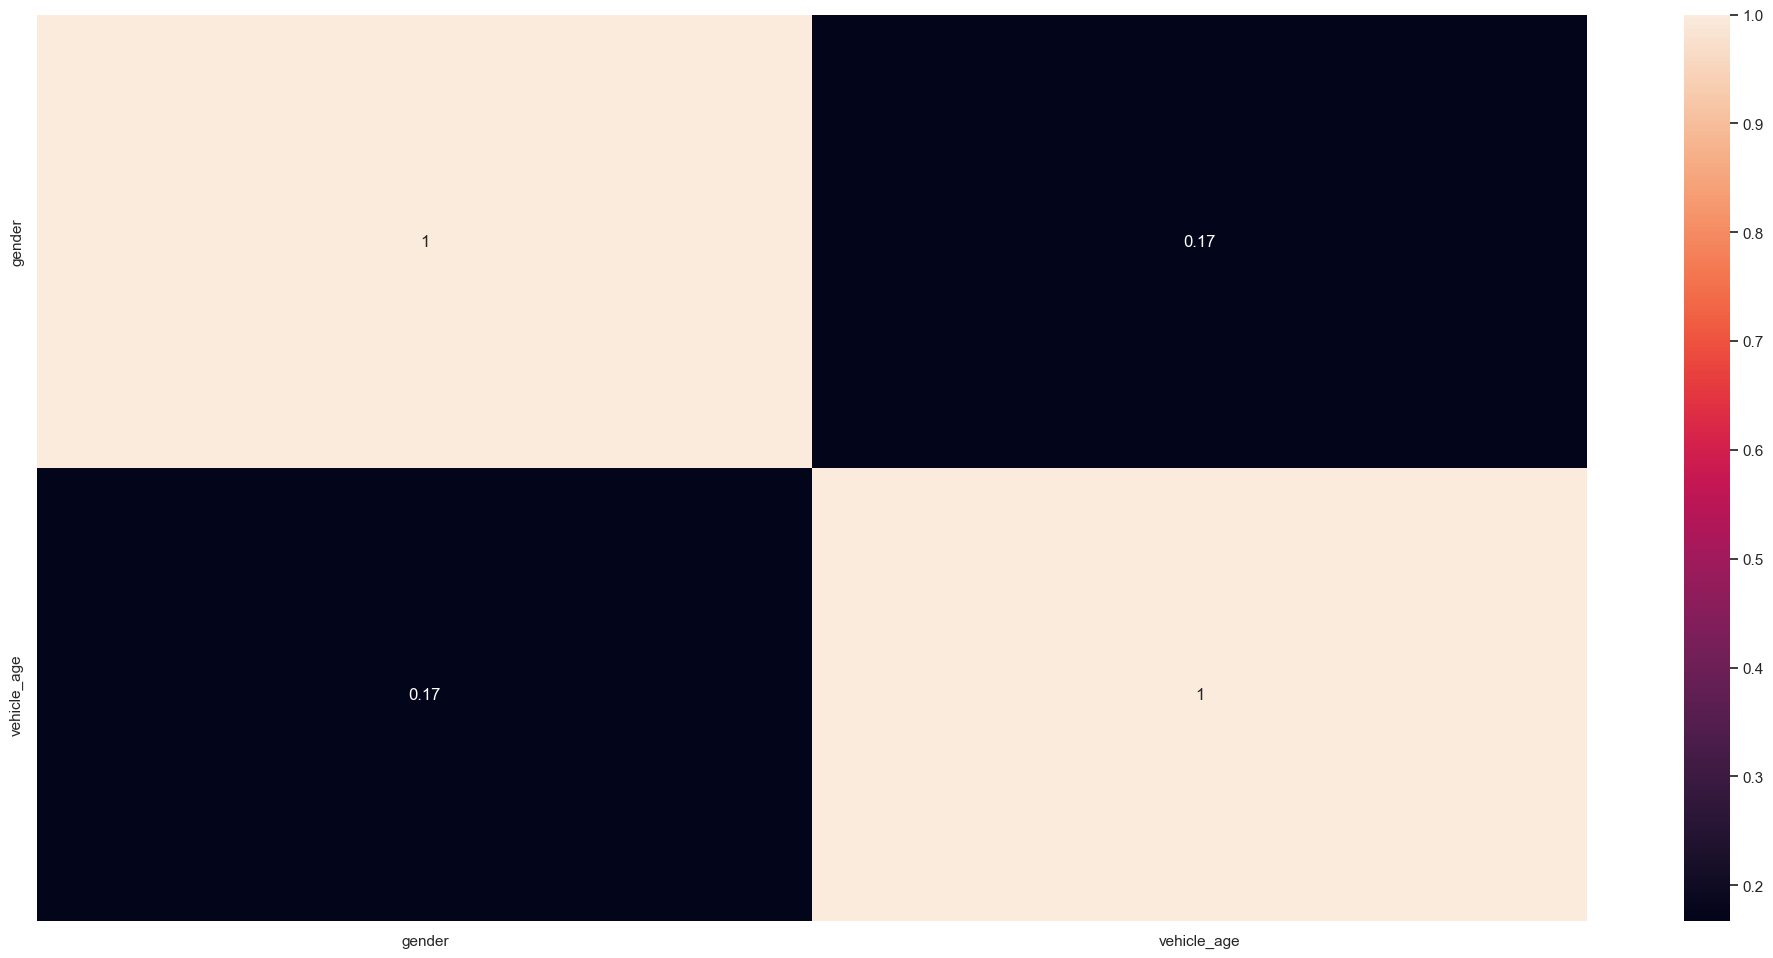

In [37]:
# only categorical data
a = df4.select_dtypes(include='object')

# Cramer V correlation
d = pycorrcat.corr_matrix(a, ['gender', 'vehicle_age'])
sns.heatmap(d, annot=True);

# 5.0 Preparação dos dados

In [38]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.20)

df5 = pd.concat([x_train, y_train], axis=1)

## 5.1 Standardization

In [39]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## 5.2 Rescaling

In [45]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# Vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

## 5.3 Transformação

### 5.3.1 Encoding

In [41]:
# gender - Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)

# region_code - Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)

# vehicle_age - One Hot Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

# 6.0 Feature Selection

## 6.1 Validation data preparation

In [48]:
# annual_premium
x_val.loc[:, 'annual_premium'] = ss.transform(x_val[['annual_premium']].values)

# Age
x_val.loc[:, 'age'] = mms_age.transform(x_val[['age']].values)

# Vintage
x_val.loc[:, 'vintage'] = mms_vintage.transform(x_val[['vintage']].values)

# gender - Target Encoding
x_val.loc[:, 'gender'] = x_val.loc[:, 'gender'].map(target_encode_gender)

# region_code - Target Encoding
x_val.loc[:, 'region_code'] = x_val.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age - One Hot Encoding
x_val = pd.get_dummies(x_val, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Frequency Encoding
x_val.loc[:, 'policy_sales_channel'] = x_val.loc[:, 'policy_sales_channel'].map(fe_policy_sales_channel)

## 6.2 feature selection per importance

In [49]:
# model definition
#forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# saving model
#pickle.dump(forest, open('F:/SamuelOliveiraAlvesd/Desktop/Data_Science/Projetos/Health_Insurance_Cross_Sell/models/extra_tree_selector.pkl', 'wb'))

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

In [ ]:
# loading model selector
file = open('F:/SamuelOliveiraAlvesd/Desktop/Data_Science/Projetos/Health_Insurance_Cross_Sell/models/extra_tree_selector.pkl','rb')
forest = pickle.load(file)
file.close()


# data preparation
x_train_f = df5.drop(['id', 'response'], axis=1)
y_train_f = y_train.values
forest.fit(x_train_f, y_train_f)

Feature ranking:
                        feature  importance
0                       vintage        0.27
0                annual_premium        0.23
0                           age        0.17
0                   region_code        0.11
0                vehicle_damage        0.07
0          policy_sales_channel        0.06
0            previously_insured        0.05
0      vehicle_age_below_1_year        0.01
0  vehicle_age_between_1_2_year        0.01
0                        gender        0.01
0      vehicle_age_over_2_years        0.00


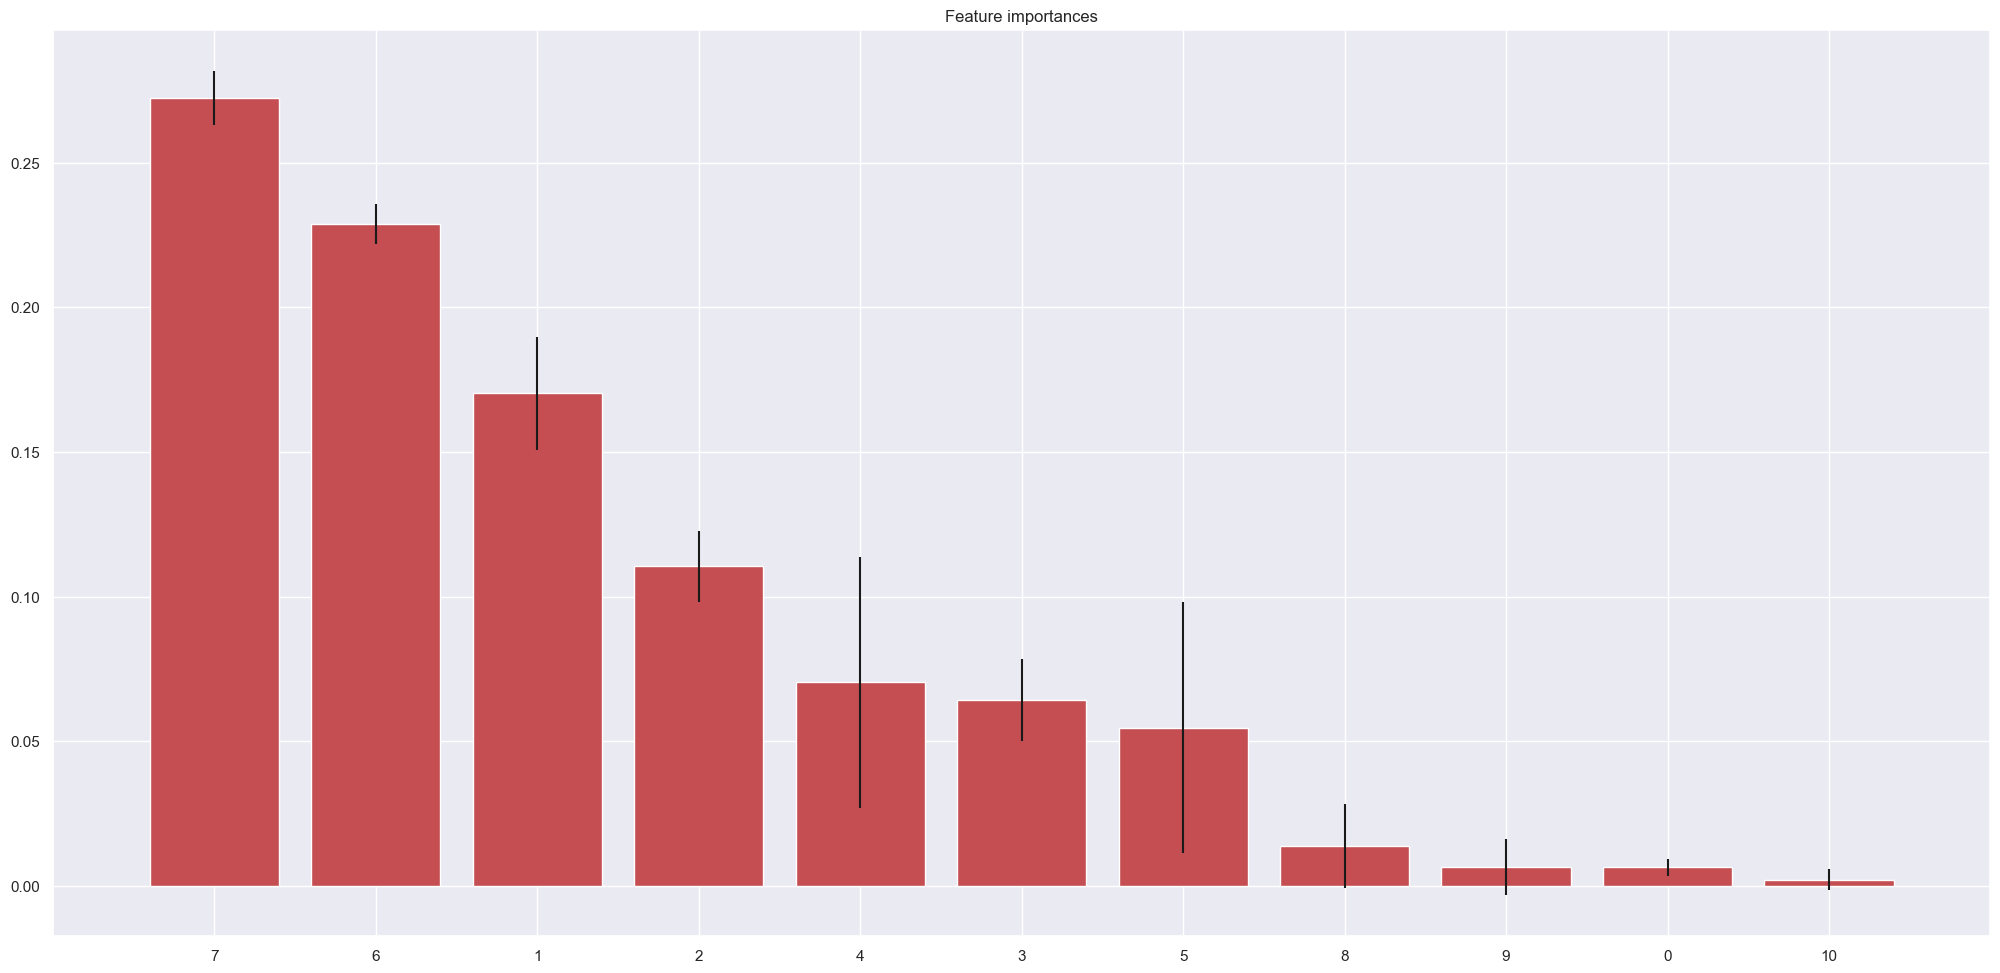

In [58]:
# Collect features from model selector
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Organize and print ranking per features
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(x_train_f, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar(range(x_train_f.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_f.shape[1]), indices)
plt.xlim([-1, x_train_f.shape[1]])
plt.show()

# 7.0 Machine Learning Modeling

## 7.1 Average model

## 7.2 Linear Regression Model

### 7.2.1 Linear Regression Model - Cross Validation

## 7.3 Linear Regression Regularized Model

### 7.3.1 Lasso - Cross Validation

## 7.4 Random Forest Regressor

### 7.4.1 Random Forest Regressor - Cross Validation

## 7.5 XGBoost Regressor

### 7.5.1 XGBoost Regressor - Cross Validation

## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

### 7.6.2 Real Performance - Cross Validation

# 8.0 Hyper Parameter Fine Tunning

## 8.1 Random Search

## 8.2 Final Model

# 9.0 Tradução e interpretação do erro

## 9.1 Bussiness Performance

## 9.2 Total Performance

## 9.3 Machine Learning Performance

# 10.0 Deploy model to production